# Introduction

Dataset used to make a model is found here: 

https://www.kaggle.com/kazanova/sentiment140


People has reached upto 83% accuracy here: 

https://www.kaggle.com/stoicstatic/twitter-sentiment-analysis-for-beginners

Aim for 85%+

Here is another one based on NN 

https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
# import seaborn as sns 

import joblib
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.naive_bayes import BernoulliNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [2]:
# import seaborn as sns

In [3]:
df = pd.read_csv('Tweet_sentiment_clean.csv', encoding='ISO-8859-1')
df.sample(10)

,sentiment,text
130885,0,user poor hun well play weekend ill hous work
245392,0,work
409617,0,want tri sim num
957772,4,user gas alwali goe upi rememb num im old
1031857,4,user good night
594754,0,damn tummi cramp
278618,0,user snap gay tad cal
322908,0,user cant file bankruptci longer exist wait nu...
201845,0,idead time call today
1430893,4,user problem yeah understand peopl want make b...


In [4]:
df['sentiment'].value_counts()

4    799789
0    799722
Name: sentiment, dtype: int64

## Model Building 

-- In future need to do all the preprocessing inside the pipeline. But it is OK for now. 

#### Use customize the validation data: because the dataset is very large. 5 fold cross valdiation is not needed. Small set would do. 

In [5]:
X = df['text']
y = df['sentiment']

In [6]:
encoder = LabelEncoder()

# We can fit_transform entire y before train_test split.
# This is because label encoding is not feature transformation. 
y = encoder.fit_transform(y)

In [7]:
X_trainvalid, X_test, y_trainvalid, y_test = \
                    train_test_split(X, y, 
                                     test_size=0.3, 
                                     random_state=77)

X_train, X_valid, y_train, y_valid = \
                    train_test_split(X_trainvalid, 
                                     y_trainvalid, 
                                     test_size=0.3, 
                                     random_state=77)

print('Train data size: \t', X_train.shape[0], 
      '\nValidation data size: \t', X_valid.shape[0], 
      '\nTest data size: \t', X_test.shape[0])

test_fold = [0 if x in X_valid.index else -1 for x in X_trainvalid.index]

ps = PredefinedSplit(test_fold)

Train data size: 	 783759 
Validation data size: 	 335898 
Test data size: 	 479854


# Stacking 

Stacking is another form of ensemble learning. In the simplest from stacking means take the predictions from various models and average them out for the final predictions. 

$$ pred_{stack} = \frac{pred_{model_1} + pred_{model_2} + \cdots pred_{model_N}}{N} $$

In most of the cases this already gives a better performance than the performance of the individual models. But we can do better than this introducing a more sofisticated stacking scheme. In thins approach we take the predictions from each model as the new features (input) of the new dataset. The target variable is again the same. We then choose another model to fit these data.  

##### Now a question is why this approach works? 
In many optimization problem the cost function is not a convex function. Meaning that there might not be a single global minima but there can be multiple global minima and even higher number of local minima. In extremely high dimensional space of the data those individual global minima can be connected to each other through what we might called a flat topological valley. When you reach at the edge of the downhill of the valley you find the minima. You can not minimize the loss function further because the gradients are already zero. In a sense it is already optimized but the more robost model exist at the middle of the flat valley. In this sense model-I might have reached the valley from one end while model-II might have reached there from different end. Averaging them take you to the center of the valley. This concept is illustrated in the plot below: 


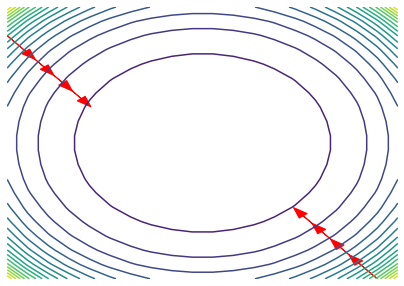

In [8]:
grids = np.linspace(-1.2, 1.2, 20)
xgrid, ygrid = np.meshgrid(grids, grids)
zgrid = np.exp((xgrid**2 + ygrid**2))
cont_loc = np.linspace(0, np.max(zgrid), 20)

def arror_series(x_start=0, y_start=0, x_incr=1, y_incr=1):
    for i in range(4):
        plt.arrow(x_start, y_start, x_incr, y_incr, head_width=0.5, fc='r', ec='r')
        x_start += x_incr
        y_start += y_incr  

plt.figure(figsize=(7, 5))
plt.contour(zgrid, cont_loc)
plt.axis('off')

arror_series(y_start=17, x_incr=0.9, y_incr=-1.1)
arror_series(x_start=18, x_incr=-0.9, y_incr=1.1)
plt.show()

In [10]:
nb_pipeline = joblib.load('nb_pipeline.pkl')
nb_pipeline.score(X_test, y_test)

0.7678606409449541

In [11]:
lr_pipeline = joblib.load('lr_pipeline.pkl')
lr_pipeline.score(X_test, y_test)

0.780718718610244

In [12]:
rf_pipeline = joblib.load('rf_pipeline.pkl')
rf_pipeline.score(X_test, y_test)

0.7006693702667894

In [13]:
xgb_pipeline = joblib.load('xgb_pipeline.pkl')
xgb_pipeline.score(X_test, y_test)

0.7064648830686

In [14]:
lgb_pipeline = joblib.load('lgb_pipeline.pkl')
lgb_pipeline.score(X_test, y_test)

0.7802143985462244

In [15]:
cbc_pipeline = joblib.load('cbc_pipeline.pkl')
cbc_pipeline.score(X_test, y_test)

0.7225343541994024

In [16]:
svc_pipeline = joblib.load('svc_pipeline.pkl')
svc_pipeline.score(X_test, y_test)

0.7675647176016038

### Simple stacking 

In [17]:
def simple_stacking(models):
    pred_total = 0
    for model in models:
        proba_model = model.predict_proba(X_test)
        pred_model = proba_model[:, 1]
        pred_total += pred_model
    pred_final = np.round(pred_total/len(models))
    return pred_final

In [23]:
rf_pipeline.predict_proba(X_test)

array([[0.52868074, 0.47131926],
       [0.48565643, 0.51434357],
       [0.5063427 , 0.4936573 ],
       ...,
       [0.4872416 , 0.5127584 ],
       [0.4917973 , 0.5082027 ],
       [0.51477648, 0.48522352]])

In [27]:
models = [lr_pipeline, nb_pipeline, \
          rf_pipeline, xgb_pipeline, lgb_pipeline, \
          cbc_pipeline]

pred_final = simple_stacking(models)
print(accuracy_score(pred_final, y_test))

0.7848345538434607


### More advanced way of stacking 

In [28]:
def stacked_features(models):
    hyper_X_train = []
    hyper_X_test = []
    for model in models:
        proba_train = model.predict_proba(X_trainvalid)
        proba_test = model.predict_proba(X_test)

        hyper_X_train.append(proba_train[:,1])
        hyper_X_test.append(proba_test[:,1])
    hyper_X_train = np.transpose(hyper_X_train)
    hyper_X_test = np.transpose(hyper_X_test)
    return hyper_X_train, hyper_X_test

In [29]:
hyper_X_train, hyper_X_test = stacked_features(models)

In [30]:
lr2 = LogisticRegression()
lr2.fit(hyper_X_train, y_trainvalid)
lr2.score(hyper_X_test, y_test)

0.7874541006222726

In [35]:
import seaborn as sns

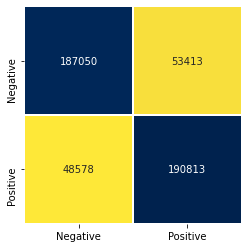

In [36]:
y_pred = lr2.predict(hyper_X_test)

sns.heatmap(confusion_matrix(y_test, y_pred), 
           xticklabels=['Negative', 'Positive'],
           yticklabels=['Negative', 'Positive'],
           linewidths=1,
           cmap='cividis_r',
           fmt='', 
           annot=True, 
           cbar=False, 
           square=True)
plt.show()

# Future direction 


- Include NN in stacking

- Include SVM in stacking. Have SVM calculating probability. Make it faster. 

- Train random forest and catBoost with larger dataset. 

- RNN for NLP 

- Hyperparameter tuning for the tree based models. 
 